This notebook acquires data to measure the gain of the SiPM. It sets the overvoltage and then takes scope and MCA data with the Red Pitaya. The scope is setup to trigger on the LED.

In [40]:
import numpy as np
import time,datetime
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
plt.style.use('../../style.mplstyle')
import sys 
sys.path.append("../../devices")
sys.path.append("../../RedPitaya")
from datetime import datetime
import pyautogui
from ipywidgets import IntProgress
import importlib 
import matplotlib
import os

In [126]:
#### set data taking parameters here #####

save_dir = "" ## name of directory to save, leave empty to use todays date as default
make_plots = True ## make diagnostic plots

breakdown_voltage = 27.4 ## Volts, breakdown to sweep keithley relative to
ov_list = np.arange(2, 7, 0.5) ## Volts, list of overvoltages to sweep

instr_to_sweep = 'keith' ## instrument to sweep over (must be 'keith' or 'synth')

red_pitaya_channel = 2 ## channel for the analog signal in the RP (1 or 2), used for MCA presumably after shaper

mca_thresh = 0 ## minimum threshold [ADC bins] for mca to record pedestal

LED_flashing_rate = 4e3


In [42]:
## setup directories for saving data
def setup_save_dir(save_dir):

    if len(save_dir) > 0:
        path = "C:/Data/{}/".format(save_dir)
    else:
        date = datetime.today().strftime('%Y%m%d')
        subdir = ''
        path = "C:/Data/{}/{}/".format(date,subdir)
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    return path

In [43]:
## import instrument control as needed
from pitaya import RedPitaya
from functiongenerator import AFG2225
from picoammeter import Keithley6487
from powersupply import NGE100
import redpitaya_mca as mca

In [44]:
nge = NGE100('USB0::0x0AAD::0x0197::5601.1414k03-100771::INSTR')
pico = Keithley6487('ASRL9::INSTR')
func = AFG2225('ASRL19::INSTR') ## first function generator
func2 = AFG2225('ASRL20::INSTR') ## second function generator

In [45]:
## turn on +/-24 Volts to power the cremat preamp
output_channel = 1 ## channel to turn on
output_voltage = 24 # Volts
nge.output(ch=output_channel, state=False)
nge.voltage(ch=output_channel, volt=output_voltage)
nge.output(ch=output_channel, state=True)

In [46]:
## setup the Keithley ahead of time and turn it on to the breakdown voltage so it starts ramping up
## will set the precise settings and loop through voltages later in the notebook

keithley_time_delay = 5 ## seconds, time to wait for the keithley to stabilize at a given voltage

if(instr_to_sweep == 'keith'):
    pico.voltage_source_state(0) ## turn off source
    pico.voltage_source_range(breakdown_voltage+np.max(ov_list)) ## set the range to accomodate the highest voltage needed
    pico.voltage(breakdown_voltage) ## set to breakdown
    pico.voltage_source_state(1) ## turn on source
    time.sleep(keithley_time_delay) ## wait for the voltage to ramp up

In [83]:
LED_dictionary = {
    'Blue': {
        'do_flash': True,
        'synth': func2,
        'channel': 1,
        'wavelength': 405,
        'pulse_width_gain': 300,
        'pulse_width_pde': 300,
        'amplitude_gain': 3.5,
        'amplitude_pde': 10.0
    },
    'UV': {
        'do_flash': True,
        'synth': func,
        'channel': 1,
        'wavelength': 310,
        'pulse_width_gain': 750,
        'pulse_width_pde': 750, # 750 could be ok, DO NOT go above
        'amplitude_gain': 8.0,
        'amplitude_pde': 10.0 
    }
}

!!!! Before running this section, make sure to start the MCA app via the web interface !!!

In [129]:
def setup_mca_data(channel_to_use, integ_time=100, min_thresh=0):

    rp = mca.mca()
    ## chan = 1/2
    ## baseline is baseline level to subtract in MCA in bits (16 bit unsigned integer). Positive values from zero to 2^15-1
    ## negative values from 2^16-1 to 2^15 
    ## integ_time is time per file in seconds
    ## min_thresh is threshold in bits at which to ignore peaks, set to non-zero to avoid collecting pedestal data
    ## baseline_mode is set to auto (can see MCA plot in red pitaya GUI to see what this does)

    rp.setup_mca(chan=channel_to_use, baseline_level=0, dec=32, integ_time = integ_time, min_thresh=min_thresh, baseline_mode='auto')
    rp.reset_histo(chan=channel_to_use)
    rp.start_histo(chan=channel_to_use)

    return rp

In [130]:
def collect_single_mca_file(red_pitaya_channel, time_per_file, mca_thresh, path, int_time, ov, fidx, label):
    # making mca histogram
        red_mca = setup_mca_data(channel_to_use=red_pitaya_channel-1, integ_time=time_per_file, min_thresh=mca_thresh) # 0 indexing for the channel, unlike above
        time.sleep(1) ## wait for setup to be ready -- otherwise it will read before buffer is full

        if(make_plots):
            fig=plt.figure()
            fig.patch.set_facecolor('white')
            hfig = display.display(fig, display_id=True)

        for i in range(int_time):
            dat = red_mca.read_histo_data(chan=1)
            #curr_time = red_mca.read_timer(chan=1)
            #print(curr_time)

            if(make_plots):
                plt.clf()
                plt.yscale('log')
                plt.plot(dat, color='k')
                plt.ylim(0.1,10000)
                plt.xlim(0,2000)
                hfig.update(fig)
            time.sleep(0.5) # adjust due to dead time

        if(make_plots):
            plt.show(fig)

        
        if fidx==-1:
            red_mca.save(dat, ch=red_pitaya_channel, tag='mca_keith_{:.2f}OV_source_{}'.format(breakdown_voltage+ov, fidx), path=path)
        else:
            red_mca.save(dat, ch=red_pitaya_channel, tag='mca_keith_{:.2f}OV_{}_{}'.format(breakdown_voltage+ov, label, fidx), path=path)

        red_mca.close()

In [50]:
def setup_LED_flash(func, synth_channel, pulse_amplitude, LED_flashing_rate, pulse_width):
    # set the LED to flash the way we want them
    # function generator (func or func2), channel (1 or 2), voltage amplitude (V), LED flashing frequency (Hz), pulse width (ns): 1ns for gain measurements, 1 us for PDE 
    amplitude_offset = pulse_amplitude/2.0 ## V, offset to give positive going pulse

    func.set_output_onoff(synth_channel, 0) ## turn off channel
    func.set_wavetype(synth_channel, "PULS") 
    func.set_pulse_width(synth_channel, pulse_width) 
    func.set_frequency(synth_channel, LED_flashing_rate)
    func.set_amplitude(synth_channel, pulse_amplitude)
    func.set_offset(synth_channel, amplitude_offset)
    func.set_output_load(synth_channel, "HZ") ## make sure the channel is set for high impedance
    func.set_output_onoff(synth_channel, 1) ## turn on channel


In [93]:
setup_LED_flash(func2, 1, 3.5, 4e3, 300)

In [127]:
save_dir = r"20230321/step14/"

## warn about overwriting files
path = setup_save_dir(save_dir)
#if( os.path.isfile(os.path.join(path, 'wavefms_keith_{:.2f}OV_{}.h5'.format(ov_list[0],0))) ):
#    resp = pyautogui.confirm("File already exists, overwrite?")
#    if( resp == "Cancel" ):
#        raise KeyboardInterrupt

def setup_measurement(meas_type, time_per_file, do_flash):

    if meas_type == 'gain':

        #time_per_file = 30 ## seconds ## for bv curve 10s per file
        int_time = int(time_per_file) #int(num_mca_events/LED_flashing_rate)
        num_files_per_ov = 1 ## 1 for bv ## more for longer source data
        
        # led

        if do_flash == True:
            for i in LED_dictionary:
                setup_LED_flash(LED_dictionary[i]['synth'], LED_dictionary[i]['channel'], LED_dictionary[i]['amplitude_gain'], LED_flashing_rate, LED_dictionary[i]['pulse_width_gain'])

                for ov in ov_list:

                    pico.voltage(breakdown_voltage + ov) 
                    time.sleep(keithley_time_delay) ## wait for voltage to ramp up

                    for fidx in range(num_files_per_ov):

                        ## collect the source file (no LED flashes)
                        collect_single_mca_file(red_pitaya_channel, time_per_file, mca_thresh, path, int_time, ov, fidx, LED_dictionary[i]['wavelength'])

                LED_dictionary[i]['synth'].set_output_onoff(LED_dictionary[i]['channel'], 0)

        else: 
            for ov in ov_list:

                pico.voltage(breakdown_voltage + ov) 
                time.sleep(keithley_time_delay) ## wait for voltage to ramp up

                for fidx in range(num_files_per_ov):

                    ## collect the source file (no LED flashes)
                    collect_single_mca_file(red_pitaya_channel, time_per_file, mca_thresh, path, int_time, ov, fidx, 'source')

    elif meas_type == 'pde':
        ov = 4 ## OV for PDE measurement
        #time_per_file = 60 ## in seconds - for source 1 min per file
        int_time = int(time_per_file) #int(num_mca_events/LED_flashing_rate)

        ## leds
        #pulse_width = 1000 ## in ns (1 us for PDE)
        time_per_file_LED = 10
        num_files_per_LED = 1

        #######################
        total_time = 6000 #7200 ## in seconds -- total run time
        num_iterations = total_time/(time_per_file+2*time_per_file_LED)

        #######################
        pico.voltage(breakdown_voltage + ov) 
        time.sleep(keithley_time_delay) ## wait for voltage to ramp up

        for fidx in range(int(num_iterations)):

            ## collect the source file (no LED flashes)
            collect_single_mca_file(red_pitaya_channel, time_per_file, mca_thresh, path, int_time, ov, fidx, 'source')

            for i in LED_dictionary:
                setup_LED_flash(LED_dictionary[i]['synth'], LED_dictionary[i]['channel'], LED_dictionary[i]['amplitude_pde'], LED_flashing_rate, LED_dictionary[i]['pulse_width_pde'])
                collect_single_mca_file(red_pitaya_channel, time_per_file_LED, mca_thresh, path, int(time_per_file_LED), ov, fidx, LED_dictionary[i]['wavelength'])
                LED_dictionary[i]['synth'].set_output_onoff(LED_dictionary[i]['channel'], 0)

    else:
        print("Warning, no measurement type defined -- set meas_type to '''gain''' or '''pde''' ")

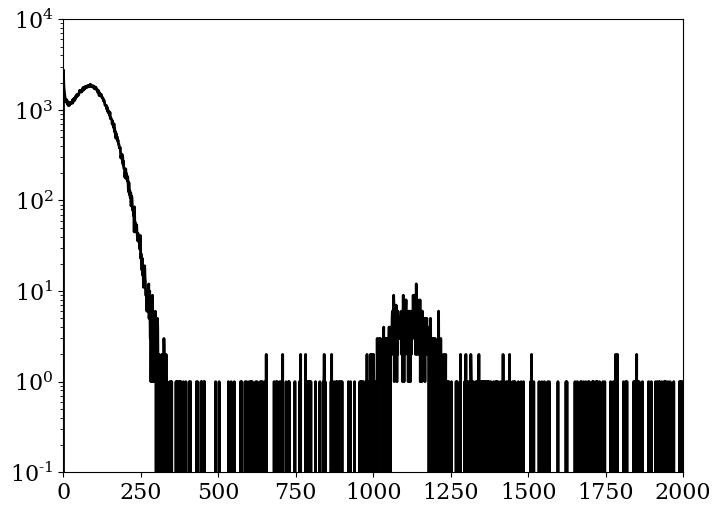

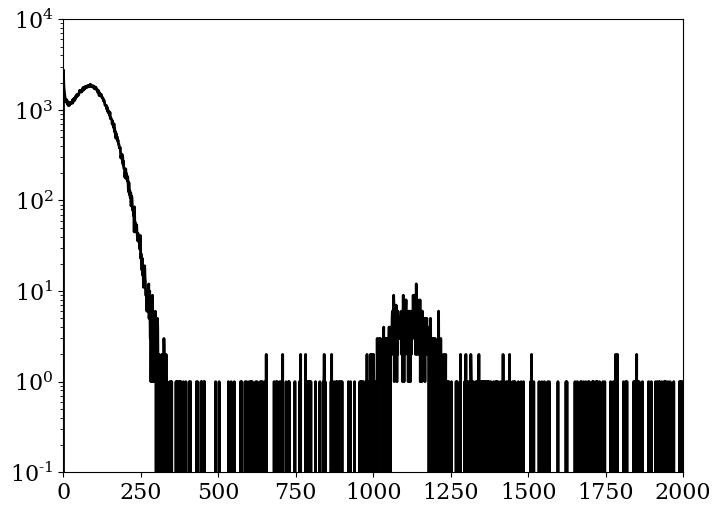

In [131]:
#True if gain meas and want LEDs, otherwise False; time_per_file = 10 (SRSgain 100), =30 (SRSgain 10 or 5), =60 (pde meas) 
setup_measurement('gain', 10, True)

In [33]:
red_mca.close()